In [3]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
# %run /Users/maayanlab/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

## Volcano Plot

In [29]:
# Get signature
signature_dataframe = pd.read_table('./s3-differential_expression.dir/baron-P1_vs_P3-biojupies.txt').rename(columns={'P.Value': 'pvalue', 'adj.P.Val': 'FDR'})#, index_col='gene_symbol')
signature_dataframe['log10P'] = -np.log10(signature_dataframe['pvalue'])

# Significance
significant = []
logfc_threshold = 1
pvalue_threshold = 0.1
for index, rowData in signature_dataframe.iterrows():
    if rowData['pvalue'] < pvalue_threshold:
        if rowData['logFC'] > logfc_threshold:
            significant.append('upregulated')
        elif rowData['logFC'] < -logfc_threshold:
            significant.append('downregulated')
        else:
            significant.append('other')
    else:
        significant.append('other')
signature_dataframe['significant'] = significant

# Get selected genes
with open('pipeline/notebooks/genes.txt') as openfile:
    genes = openfile.read().split('\n')
signature_dataframe['selected'] = [x in genes for x in signature_dataframe['gene_symbol']]
print(sum(signature_dataframe['FDR'] < 0.05))
print(sum(signature_dataframe['FDR'] < 0.1))
signature_dataframe.head()

23
59


gene_symbol     logFC   AveExpr         t    pvalue       FDR         B  \
0        Tcf7  0.736840  5.308046  8.959872  0.000016  0.041963  3.426975   
1       Atp7b  0.522714  5.494272  8.709495  0.000020  0.041963  3.178158   
2       Magi1  0.453348  5.753852  7.726496  0.000049  0.045781  2.196662   
3     Rap1gap  0.945534  2.317261  7.644296  0.000053  0.045781  2.478156   
4     Tnfaip2  0.590153  4.726842  7.473378  0.000062  0.045781  2.081253   

     log10P significant  selected  
0  4.788514       other      True  
1  4.696200       other     False  
2  4.311428       other     False  
3  4.277517       other     False  
4  4.206086       other     False

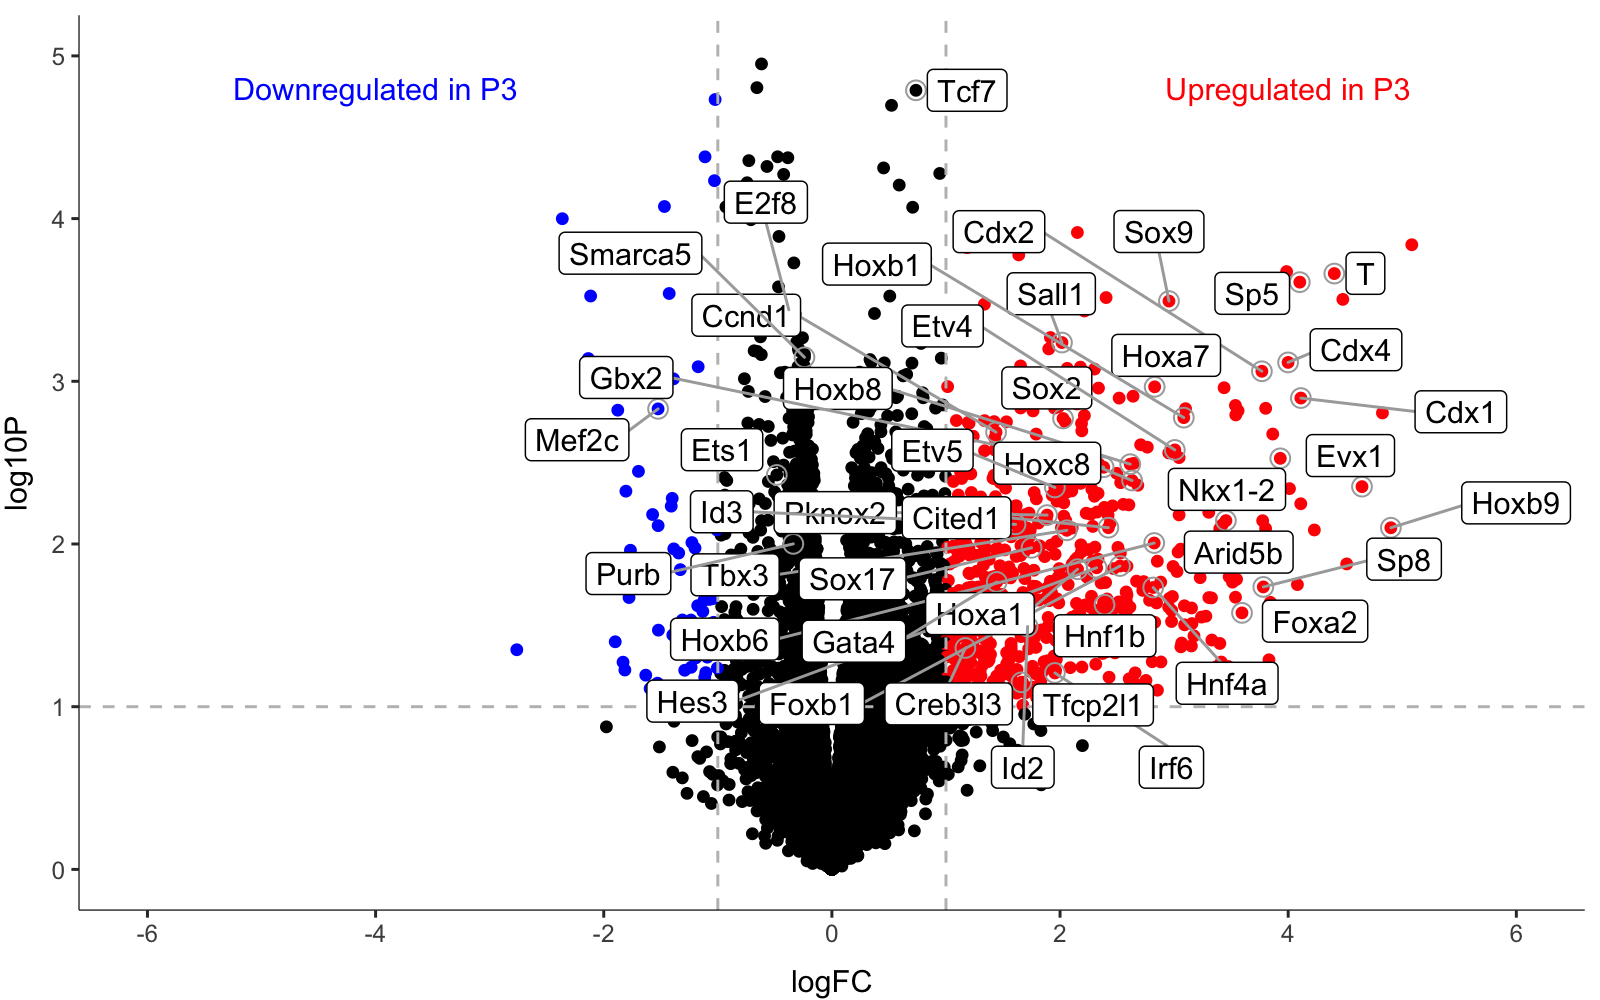

In [34]:
%%R -i signature_dataframe,logfc_threshold,pvalue_threshold -h 1000 -w 1600 -r 200
ticks <- seq(-6, 6, by=2)
signature_dataframe_subset <- signature_dataframe[signature_dataframe$selected,]
ggplot(signature_dataframe, aes(x=logFC, y=log10P, color=significant)) +
    geom_point() +
    annotate("text", label="Upregulated in P3", x=4, y=4.8, color='red') + 
    annotate("text", label="Downregulated in P3", x=-4, y=4.8, color='blue') + 
    scale_color_manual(values=c('blue', 'black', 'red')) +
    scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
    scale_y_continuous(lim=c(0, 5)) +
    geom_vline(xintercept=logfc_threshold, color='grey', lty=2) +
    geom_vline(xintercept=-logfc_threshold, color='grey', lty=2) +
    geom_hline(yintercept=-log10(pvalue_threshold), color='grey', lty=2) +
    geom_point(data=signature_dataframe_subset, color='darkgrey', shape=1, size=3) +
    ggrepel::geom_label_repel(data=signature_dataframe_subset, aes(x=logFC, y=log10P, label=gene_symbol), color='black', hjust=0, nudge_x=0.1, segment.color='darkgrey') + 
    #labs(title = '', x = '', y = '', color = '', fill='') +
    guides(color=FALSE) +
    theme_classic() +
    theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))

## Outlier Comparison

In [115]:
signature_dataframe_withoutlier = pd.read_table('./s3-differential_expression.dir/baron-P1_vs_P3-limma-withoutlier.txt').rename(columns={'P.Value': 'pvalue', 'adj.P.Val': 'FDR'})#, index_col='gene_symbol')
signature_dataframe_withoutlier.head()

gene_symbol     logFC   AveExpr         t    pvalue       FDR         B
0        Plek  2.586026  2.798499  9.379795  0.000001  0.005685  6.113583
1       Rap1b  0.640690  8.062169  8.797055  0.000002  0.005685  5.145112
2      Prokr2  2.382757 -0.611521  8.821870  0.000002  0.005685  4.976889
3      Med12l  1.046439  3.457969  8.447867  0.000003  0.005685  4.968828
4        Egfr  1.898184 -0.696462  8.543822  0.000003  0.005685  4.693116

In [117]:
signature_dataframe.head()

gene_symbol     logFC   AveExpr          t        pvalue       FDR  \
0       Dusp4 -2.687771  2.701526 -11.409484  2.848866e-07  0.000919   
1       Sall1 -2.419528  3.129191 -11.293920  3.148546e-07  0.000919   
2       Epha1 -2.477959  1.532139 -10.934833  4.320772e-07  0.000919   
3      Mogat2 -3.018023  2.941332 -10.893841  4.482252e-07  0.000919   
4       Epha2 -2.509838  1.857811 -10.604912  5.824772e-07  0.000919   

          B    log10P  
0  7.416196  6.545328  
1  7.291094  6.501890  
2  6.958261  6.364439  
3  6.949021  6.348504  
4  6.701884  6.234721

In [118]:
merged_dataframe = signature_dataframe.merge(signature_dataframe_withoutlier, on='gene_symbol', suffixes=('all', 'filtered'))
merged_dataframe.head()

gene_symbol  logFCall  AveExprall       tall     pvalueall    FDRall  \
0       Dusp4 -2.687771    2.701526 -11.409484  2.848866e-07  0.000919   
1       Sall1 -2.419528    3.129191 -11.293920  3.148546e-07  0.000919   
2       Epha1 -2.477959    1.532139 -10.934833  4.320772e-07  0.000919   
3      Mogat2 -3.018023    2.941332 -10.893841  4.482252e-07  0.000919   
4       Epha2 -2.509838    1.857811 -10.604912  5.824772e-07  0.000919   

       Ball    log10P  logFCfiltered  AveExprfiltered  tfiltered  \
0  7.416196  6.545328      -2.132369         2.602887  -5.710596   
1  7.291094  6.501890      -1.998569         3.008426  -6.653402   
2  6.958261  6.364439      -1.542711         1.370806  -2.711442   
3  6.949021  6.348504      -2.079645         2.777702  -3.579606   
4  6.701884  6.234721      -1.857545         1.716380  -4.381397   

   pvaluefiltered  FDRfiltered  Bfiltered  
0        0.000115     0.026740   1.350087  
1        0.000029     0.020963   2.679287  
2        0.019562     0.163318  -3.529821  
3        0.004046     0.094342  -2.300848  
4        0.000991     0.059038  -0.664885

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



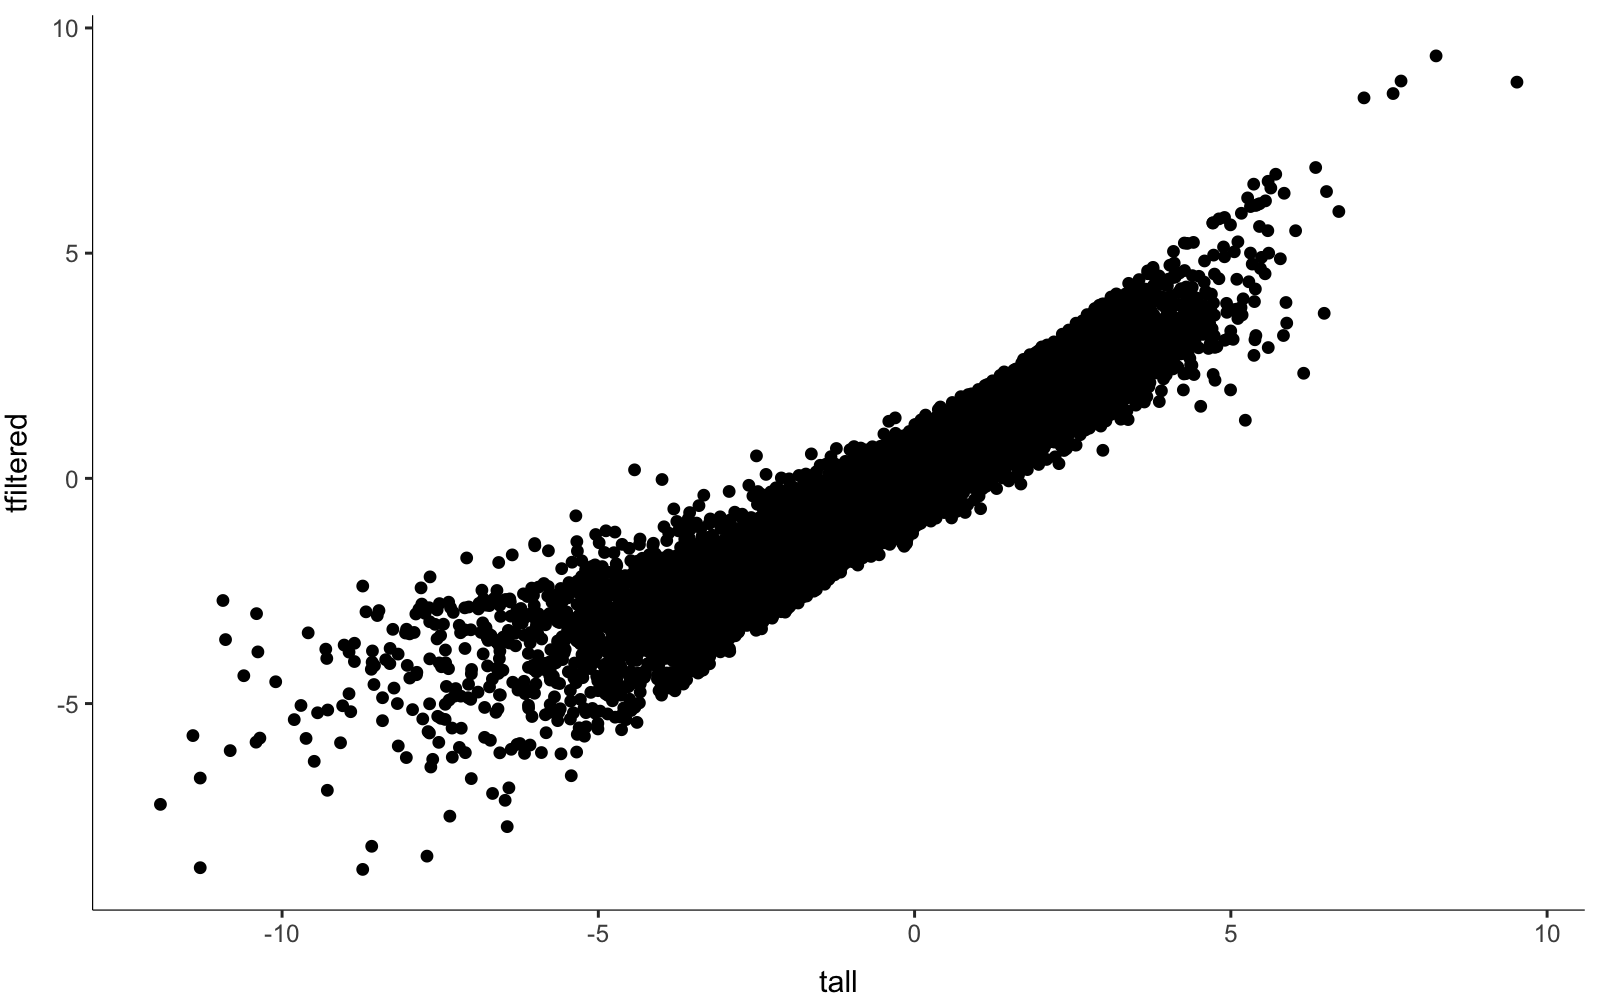

In [119]:
%%R -i merged_dataframe -h 1000 -w 1600 -r 200
#ticks <- seq()
ggplot(merged_dataframe, aes(x=tall, y=tfiltered)) +
geom_point() +
#facet_wrap(~, scales='free') +
#coord_flip() +
#scale_fill_manual(values=c('', '')) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
#geom_abline(intercept=0, slope=1) +
#xlab('') +
#ylab('') +
#labs(title = '', x = '', y = '', color = '', fill='') +
#guides(fill=FALSE) +
theme_classic() +
theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))

## Heatmap

In [190]:
count_dataframe = pd.read_table('./s2-expression.dir/baron-star_counts.txt', index_col='gene_symbol')
count_dataframe.head()

P1-1  P1-2  P1-3  P2-1  P2-2  P2-3  P3-1  P3-2  P3-3  DN-1  \
gene_symbol                                                                 
0610009B22Rik   623   665   605   544   742   484   677   634   528   598   
0610010F05Rik  1993  1757  1861  1661  1892  1759  1836  1454  1291  1665   
0610010K14Rik    51    62    48    50    47    62    50    52    45    57   
0610012G03Rik  1590  1042  1097   854  1140  1202  1274  1263  1235   775   
0610030E20Rik  1986  2111  1984  1905  2252  2005  2143  2045  1856  2007   

               DN-2  DN-3  
gene_symbol                
0610009B22Rik   180   807  
0610010F05Rik   512  1874  
0610010K14Rik    24    90  
0610012G03Rik   227  1083  
0610030E20Rik   633  2561

In [191]:
logcpm_dataframe = np.log10((count_dataframe/count_dataframe.sum())*10**6+1)[['P1-1', 'P1-2', 'P1-3', 'P3-2', 'P3-3']]
logcpm_dataframe.head()

P1-1      P1-2      P1-3      P3-2      P3-3
gene_symbol                                                    
0610009B22Rik  1.165939  1.198243  1.159776  1.196653  1.160001
0610010F05Rik  1.650092  1.602748  1.626990  1.541269  1.530162
0610010K14Rik  0.325864  0.376293  0.315312  0.343982  0.331768
0610012G03Rik  1.554439  1.383219  1.404531  1.481992  1.511483
0610030E20Rik  1.648598  1.680643  1.654149  1.685773  1.683896

In [211]:
dge = signature_dataframe[[x != 'other' for x in signature_dataframe['significant']]]['gene_symbol'].values
print(len(dge))

1151


In [212]:
heatmap_dataframe = logcpm_dataframe.loc[dge].T.apply(ss.zscore).T

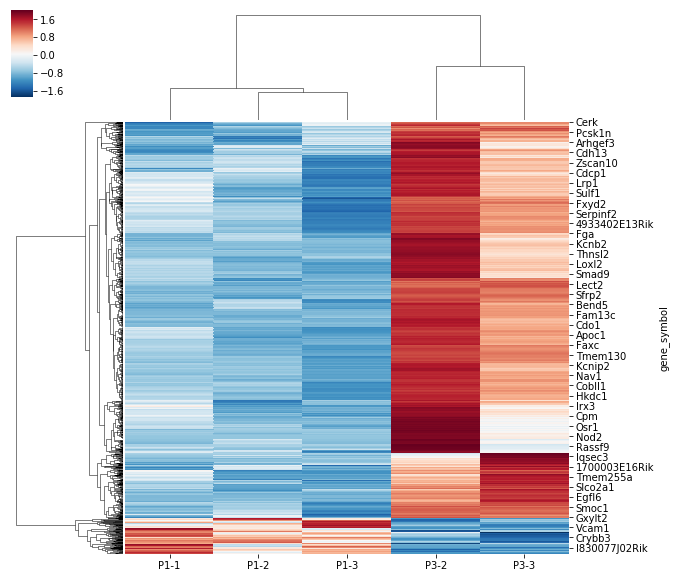

In [213]:
sns.clustermap(heatmap_dataframe, cmap="RdBu_r");